![](http://osloyi5le.bkt.clouddn.com/NLP%E6%A1%88%E4%BE%8Bbanner.jpg)

# 酒店评论情感分析项目
notebook author: [@寒小阳](https://blog.csdn.net/han_xiaoyang)

## 0.关于情感分析(sentiment analysis)

![](./imgs/sentiment_analysis1.png)

对于机器学习、深度学习和自然语言处理感兴趣的宝宝们，**“情感分析”(sentiment analysis)**这个词大家应该不陌生吧？

维基百科上，情感分析的定义是：
>文本情感分析（也称为意见挖掘）是指用自然语言处理、文本挖掘以及计算机语言学等方法来识别和提取原素材中的主观信息。

听着很高大上，是吧？如果说得具体一点呢？

>给你一段文本，你就可以用情感分析的自动化方法获得这一段内容里包含的情感色彩是什么。

挺有意思吧？不过情感分析不是炫技工具，它在各个领域有着非常强大的作用。早在2010年，就有学者指出，可以依靠Twitter公开信息的情感分析来预测股市的涨落，准确率高达87.6%！
>![](https://upload-images.jianshu.io/upload_images/64542-3e08d7b4ae239ab7.jpg)

## 1.酒店评论情感分析问题背景

![](./imgs/hotel_sentiment.png)
![](./imgs/hotel_sentiment2.png)

我们这里解决的问题，是一个具体场景下的性感分析，准确一点说，是我们想借助自然语言处理对文本的情感分类能力，自动对**酒店评论**数据进行情感分析，进而可以借助情感分析的结果完成酒店的筛选。

## 2.数据读取
我们从网络上爬取了部分酒店评论数据，用于这个场景的模型构建。

### 2.1 工具库

In [1]:
# 引入部分工具库
__author__ = 'Hanxiaoyang'

import warnings
warnings.filterwarnings("ignore")
import jieba    #分词包
import numpy    #numpy计算包
import codecs   #codecs提供的open方法来指定打开的文件的语言编码，它会在读取的时候自动转换为内部unicode 
import pandas as pd  
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)
from wordcloud import WordCloud#词云包

### 2.2 停用词

In [10]:
# 读取停用词
stopwords = []
for line in open("/home/ds/data/data/stopWord.txt"):
    stopwords.append(line.strip())

In [15]:
stopwords[15:25]

['啊', '阿', '哎', '哎呀', '哎哟', '唉', '俺', '俺们', '按', '按照']

### 2.3 读取评论数据

In [77]:
# 定义数据读取函数
def read_file(in_f, sentiment, stopwords, words, sentences):
    for line in open(in_f):
        try:
            segs = jieba.lcut(line.strip())
            # 停用词过滤
            segs = [word for word in segs if word not in stopwords and len(word)>1]
            # 记录词语
            words.extend(segs)
            # 添加 (分词评论, 情感) 的元组
            sentences.append((segs, sentiment))
        except:
            print(line)
            continue

# 读取数据
words = []
sentences = []
# 好评数据
sentiment = 1
read_file("/home/ds/data/data/1000_pos.txt", 1, stopwords, words, sentences)
# 差评数据
sentiment = 0
read_file("/home/ds/data/data/1000_neg.txt", 0, stopwords, words, sentences)

In [78]:
words[:5]

['距离', '川沙', '公路', '较近', '公交']

In [79]:
sentences[:2]

[(['距离', '川沙', '公路', '较近', '公交', '指示', '蔡陆线', '麻烦', '建议', '路线', '房间', '较为简单'],
  1),
 (['商务', '大床', '房间', '很大', '床有', '2M', '整体', '感觉', '经济', '实惠', '不错'], 1)]

## 3.数据分析

In [80]:
words_df=pd.DataFrame({'评论词语':words})
words_stat=words_df.groupby(by=['评论词语'])['评论词语'].agg({"计数":numpy.size})
words_stat=words_stat.reset_index().sort_values(by=["计数"],ascending=False)
words_stat.head(10)

,评论词语,计数
7465,酒店,1840
3984,房间,1398
4803,服务,646
843,不错,589
1526,入住,499
5091,比较,422
3881,感觉,376
6880,设施,332
1855,前台,330
4557,早餐,321


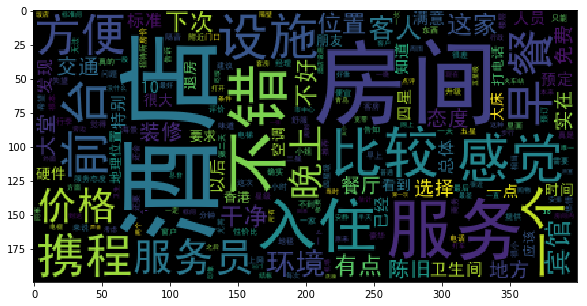

In [81]:
wordcloud=WordCloud(font_path="/home/ds/data/data/simhei.ttf",background_color="black",max_font_size=80)
word_frequence = {x[0]:x[1] for x in words_stat.head(1000).values}
wordcloud=wordcloud.fit_words(word_frequence)
plt.imshow(wordcloud)

## 4.机器学习解决方案

我们来使用机器学习的知识解决一下这个中文酒店评论数据情感分析的问题。

In [82]:
# 切分数据
from sklearn.model_selection import train_test_split
x, y = zip(*sentences)
x = [" ".join(sentence) for sentence in x]
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1, test_size=0.1)

In [83]:
len(x_train) #1800条评论作为训练集

1800

In [84]:
x_train[:2]

['酒店 比较 房间 还好 酒店 市中心 但离 出差 公司 较近 几次', '第二次 入住 客户 很近 图个 方便']

In [85]:
y_train[:2]

[1, 0]

In [86]:
# 特征抽取
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(
    ngram_range=(1,2),  # 使用长度为1和2的ngram
    max_features=1000,  # 保留最高频的1000个ngrams
)
vec.fit(x_train)

def get_features(x):
    vec.transform(x)

In [87]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(vec.transform(x_train), y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [88]:
classifier.score(vec.transform(x_test), y_test)

0.86

> 可以替换成其他的分类器，比如 逻辑斯蒂回归、SVM...

> 大家可以自行尝试

## 5.深度学习解决方案

![](./imgs/LSTM.png)

In [89]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
import json
import pandas as pd

Using TensorFlow backend.


In [91]:
tokenizer = Tokenizer(nb_words = 2500, split=' ')
tokenizer.fit_on_texts(x)
X = tokenizer.texts_to_sequences(x)
X = pad_sequences(X)

In [117]:
# 设定embedding维度等超参数
embed_dim = 16
lstm_out = 100
batch_size= 32

# 构建LSTM网络完成情感分析
model = Sequential()
model.add(Embedding(2500, embed_dim, input_length = X.shape[1], dropout=0.2))
model.add(LSTM(lstm_out, dropout_U=0.2, dropout_W=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

Y = pd.get_dummies(pd.DataFrame({'label':[str(target) for target in y]})).values
X_train, X_valid, Y_train, Y_valid = train_test_split(X,Y, test_size = 0.10, random_state = 2018)

# 拟合与训练模型
model.fit(X_train, Y_train, batch_size =batch_size, nb_epoch=10)

# 结果评估
score,acc = model.evaluate(X_valid, Y_valid, verbose = 2, batch_size = batch_size)
print("Logloss损失: %.2f" % (score))
print("验证集的准确率: %.2f" % (acc))

Epoch 1/10
1800/1800 [==============================] - 9s 5ms/step - loss: 0.6813 - acc: 0.5561
Epoch 2/10
1800/1800 [==============================] - 7s 4ms/step - loss: 0.4817 - acc: 0.8061
Epoch 3/10
1800/1800 [==============================] - 8s 4ms/step - loss: 0.3388 - acc: 0.8611
Epoch 4/10
1800/1800 [==============================] - 8s 4ms/step - loss: 0.2317 - acc: 0.9067
Epoch 5/10
1800/1800 [==============================] - 8s 4ms/step - loss: 0.1835 - acc: 0.9367
Epoch 6/10
1800/1800 [==============================] - 8s 4ms/step - loss: 0.1348 - acc: 0.9500
Epoch 7/10
1800/1800 [==============================] - 8s 4ms/step - loss: 0.1033 - acc: 0.9667
Epoch 8/10
1800/1800 [==============================] - 8s 4ms/step - loss: 0.0876 - acc: 0.9694
Epoch 9/10
1800/1800 [==============================] - 8s 4ms/step - loss: 0.0629 - acc: 0.9778
Epoch 10/10
1800/1800 [==============================] - 8s 4ms/step - loss: 0.0576 - acc: 0.9789
Logloss损失: 0.36
验证集的准确率: 0.91